## Need to get accurate detection working.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

Use the code from `diffimTests.py`.

In [2]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., 
                         #varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         varSourceChange=[1500., 1500., 1500.],
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

print dit.computeClippedImageStats(testObj.im1.im)
print dit.computeClippedImageStats(testObj.im2.im)
print dit.computeClippedImageStats(testObj.im1.var)
print dit.computeClippedImageStats(testObj.im2.var)

(0.058941207521673616, 17.142582277831181, -74.0, 1741.5550996425638)
(0.16737836510966672, 17.213964844536303, -82.0, 1169.0572762553779)
(300.05894120752163, 17.142582277831185, 226.0, 2041.5550996425638)
(300.16737836510964, 17.213964844536303, 218.0, 1469.0572762553779)


In [3]:
src = testObj.runTest(returnSources=True)

/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


In [4]:
changedCentroid = np.array(testObj.centroids[testObj.changedCentroidInd, :])
print changedCentroid

#print src['AL'][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_PsfFlux_fluxSigma', 'base_PsfFlux_flag']]
print src['ALstack'][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_PsfFlux_fluxSigma', 'base_PsfFlux_flag']]
print src['ALstack_noDecorr'][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_PsfFlux_fluxSigma', 'base_PsfFlux_flag']]
print src['ZOGY'][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_PsfFlux_fluxSigma', 'base_PsfFlux_flag']]
# For SZOGY, the correct flux measurement is PeakLikelihoodFlux
print src['SZOGY'][['base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_PeakLikelihoodFlux_fluxSigma', 'base_PsfFlux_flag']]

[[   245.89925013    279.36159005   1423.89964966   2923.89964966]
 [   287.15359438    287.4644825   11199.22125222  12699.22125222]
 [   262.66886207    301.46927489  20097.66173206  21597.66173206]]
   base_NaiveCentroid_x  base_NaiveCentroid_y  base_PsfFlux_fluxSigma base_PsfFlux_flag
1            245.307952            278.275991              177.827696             False
2            286.278808            287.187174              220.662824             False
3            262.222089            301.121689              261.953056             False
   base_NaiveCentroid_x  base_NaiveCentroid_y  base_PsfFlux_fluxSigma base_PsfFlux_flag
0            415.108090             35.051215              235.803134             False
1            245.275114            278.249775              140.383570             False
2            286.249276            287.167885              182.561723             False
3            262.198493            301.115166              214.287964             False
   bas

In [5]:
dist = np.sqrt(np.add.outer(src['ALstack'].base_NaiveCentroid_x, -changedCentroid[:, 0])**2. + \
               np.add.outer(src['ALstack'].base_NaiveCentroid_y, -changedCentroid[:, 1])**2.) # in pixels
print dist
matches = np.where(dist <= 1.5)
print matches
true_pos = len(matches[0])
false_neg = changedCentroid.shape[0] - len(matches[0])
false_pos = src['ALstack'].shape[0] - len(matches[0])
print true_pos, false_neg, false_pos

[[  1.23618698  42.84257411  28.97118577]
 [ 41.13087007   0.91768776  27.59362158]
 [ 27.20178292  28.42708623   0.56605801]]
(array([0, 1, 2]), array([0, 1, 2]))
3 0 0


In [6]:
dist = np.sqrt(np.add.outer(src['SZOGY'].base_NaiveCentroid_x, -changedCentroid[:, 0])**2. + \
               np.add.outer(src['SZOGY'].base_NaiveCentroid_y, -changedCentroid[:, 1])**2.) # in pixels
print dist
matches = np.where(dist <= 1.5)
true_pos = len(matches[0])
false_neg = changedCentroid.shape[0] - len(matches[0])
false_pos = src['SZOGY'].shape[0] - len(matches[0])
print true_pos, false_neg, false_pos

[[   0.3679381    42.0070885    27.96577874]
 [  41.8353324     0.42377499   28.29349024]
 [  27.07604939   28.51499245    0.70686497]
 [ 222.5839333   180.55095469  203.10409712]]
3 0 1


In [7]:
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., 
                         varSourceChange=[1500.], #1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

det = testObj.runTest()
print det

{'ZOGY': {'FP': 0, 'FN': 0, 'TP': 1}, 'ALstack': {'FP': 0, 'FN': 0, 'TP': 1}, 'SZOGY': {'FP': 1, 'FN': 0, 'TP': 1}, 'ALstack_noDecorr': {'FP': 1, 'FN': 0, 'TP': 1}}


Try some real tests!

In [8]:
# Default 10 sources with same flux
def runTest(flux, seed=66, sky=300., n_sources=50, n_varSources=1):
    sky = 300.
    testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., 
                             varSourceChange=np.repeat(flux, n_varSources),
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(500,30000), seed=seed, psfSize=13)
    det = testObj.runTest(subtractMethods=['ALstack', 'ZOGY', 'ZOGY_S', 'ALstack_noDecorr']) #, 'AL'])
    det['flux'] = flux
    return det

#testResults = [runTest(f, seed) for f in [1500, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000] for \
#              seed in [66, 67, 68, 69, 70]]

inputs = [(f, seed) for f in np.arange(1500, 3001, 100) for seed in np.arange(66, 86, 1)]
print len(inputs)
testResults = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1]) for i in inputs)

320


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   39.5s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 320 out of 320 | elapsed:  6.5min finished


FN: {'ZOGY': '0.0312', 'ALstack': '0.0219', 'SZOGY': '0.0000', 'ALstack_noDecorr': '0.0156'}
FP: {'ZOGY': '0.0813', 'ALstack': '0.0719', 'SZOGY': '0.1000', 'ALstack_noDecorr': '0.5719'}
TP: {'ZOGY': '0.9688', 'ALstack': '0.9781', 'SZOGY': '1.0000', 'ALstack_noDecorr': '0.9844'}


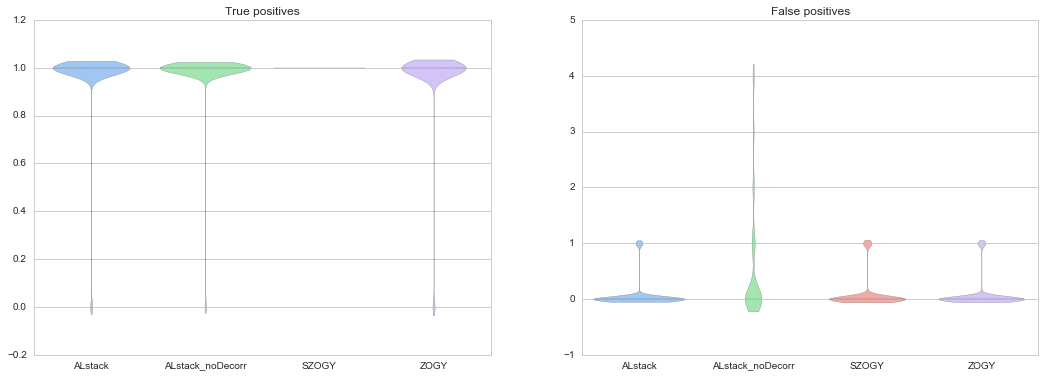

In [14]:
%precision tr = testResults
FN = {key: ("%.4f" % np.array([t[key]['FN'] for t in tr]).mean()) for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']}
FP = {key: "%.4f" % np.array([t[key]['FP'] for t in tr]).mean() for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']}
TP = {key: "%.4f" % np.array([t[key]['TP'] for t in tr]).mean() for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']}
print 'FN:', FN
print 'FP:', FP
print 'TP:', TP

FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']})
FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']})
TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']})
#sizeme(FN)

matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.2, ax=axes[0])
axes[0].set_title('True positives')
sns.violinplot(data=FP, inner="quart", cut=True, linewidth=0.3, bw=0.2, ax=axes[1])
axes[1].set_title('False positives')

In [15]:
inputs = [(f, seed) for f in np.repeat(1500, 10) for seed in np.arange(66, 86, 1)]
print len(inputs)
testResults2 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=100) for i in inputs)

200


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   51.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:  5.1min finished


FN: {'ZOGY': '0.0000', 'ALstack': '0.0000', 'SZOGY': '0.0000', 'ALstack_noDecorr': '0.0000'}
FP: {'ZOGY': '0.0500', 'ALstack': '0.0500', 'SZOGY': '0.1000', 'ALstack_noDecorr': '0.2500'}
TP: {'ZOGY': '1.0000', 'ALstack': '1.0000', 'SZOGY': '1.0000', 'ALstack_noDecorr': '1.0000'}


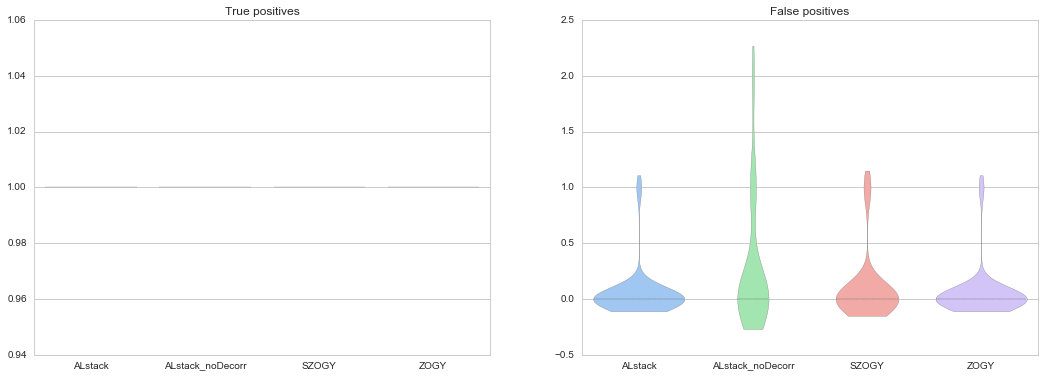

In [16]:
tr = testResults2
FN = {key: "%.4f" % (np.array([t[key]['FN'] for t in tr]).mean()) for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']}
FP = {key: "%.4f" % (np.array([t[key]['FP'] for t in tr]).mean()) for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']}
TP = {key: "%.4f" % (np.array([t[key]['TP'] for t in tr]).mean()) for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']}
print 'FN:', FN
print 'FP:', FP
print 'TP:', TP

FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']})
FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']})
TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']})
#sizeme(FN)

matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[0])
axes[0].set_title('True positives')
sns.violinplot(data=FP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[1])
axes[1].set_title('False positives')

In [17]:
inputs = [(f, seed) for f in np.arange(1000, 2000, 25) for seed in np.arange(66, 86, 1)]
print len(inputs)
testResults3 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=500) for i in inputs)

800


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  8.0min
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed: 18.8min
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed: 33.7min
[Parallel(n_jobs=8)]: Done 800 out of 800 | elapsed: 41.9min finished


FN: {'ZOGY': '0.0475', 'ALstack': '0.0450', 'SZOGY': '0.0500', 'ALstack_noDecorr': '0.0450'}
FP: {'ZOGY': '0.0725', 'ALstack': '0.0187', 'SZOGY': '0.1275', 'ALstack_noDecorr': '0.1200'}
TP: {'ZOGY': '0.9525', 'ALstack': '0.9550', 'SZOGY': '0.9500', 'ALstack_noDecorr': '0.9550'}


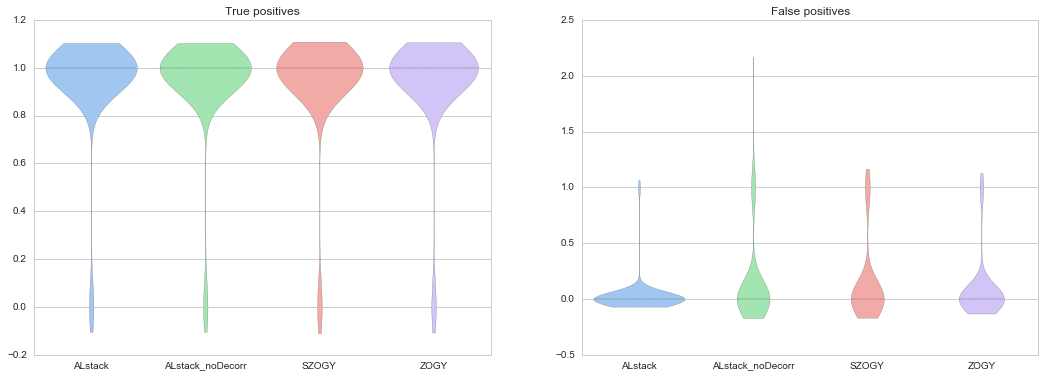

In [18]:
tr = testResults3
FN = {key: "%.4f" % (np.array([t[key]['FN'] for t in tr]).mean()) for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']}
FP = {key: "%.4f" % (np.array([t[key]['FP'] for t in tr]).mean()) for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']}
TP = {key: "%.4f" % (np.array([t[key]['TP'] for t in tr]).mean()) for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']}
print 'FN:', FN
print 'FP:', FP
print 'TP:', TP

FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']})
FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']})
TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']})
#sizeme(FN)

matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[0])
axes[0].set_title('True positives')
sns.violinplot(data=FP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[1])
axes[1].set_title('False positives')